# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [4]:
PATH = "data/demand-forecasting/"

# Helper Functions

In [5]:
def add_datepart(df, fldname, drop=True, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [6]:
def apply_cats(df, trn):
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)

In [7]:
def smape(y_pred,y_true):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

In [8]:
def print_scores(pred,label):
    rmse = np.sqrt(mean_squared_error(pred,label))
    mae = mean_absolute_error(pred,label)
    smape_score = smape(pred,label)
    
    print('RMSE: ' + str(rmse))
    print('MAE: ' + str(mae))
    print('SMAPE: ' + str(smape_score))

In [9]:
def plot_preds(pred,label):  
    
    plt.xlabel('Actual Y ')
    plt.ylabel('Predicted Y')
    
    x = np.linspace(0.0, 200.0)
    y = x
    plt.plot(x, y, 'r')
    
    plt.scatter(label,pred,alpha=0.2)
    plt.show()

# Pre-Process Data

In [10]:
train = pd.read_csv(f'{PATH}train.csv', parse_dates=['date'])
test = pd.read_csv(f'{PATH}test.csv', parse_dates=['date'])

In [11]:
add_datepart(train, 'date',drop=False)
add_datepart(test, 'date', drop=False)

In [12]:
cat_vars = ['store', 'item', 'Month', 'Week', 'Day','Dayofweek', 'Dayofyear']
contin_vars = ['Year', 'Elapsed'] 

# Elapsed = Unix Timestamp ( 0 = 1 Jan 1970 12.00am and can be negative)
# Discared date categorical variables
# 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start','Is_year_end', 'Is_year_start'

In [13]:
# Reorg train and test dataset
dependent = 'sales'
train = train[cat_vars+contin_vars+[dependent, 'date']].copy()

test[dependent] = 0 # broadcast zero for 'Sales' dummy col
test = test[cat_vars+contin_vars+[dependent, 'date', 'id']].copy()

In [14]:
for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()

In [15]:
apply_cats(test, train)

In [16]:
for v in contin_vars:
    train[v] = train[v].fillna(0).astype('float32')
    test[v] = test[v].fillna(0).astype('float32')

In [17]:
sales = train['sales'].copy()
train.drop(columns=['date','sales'],inplace=True)
test.drop(columns=['date','sales','id'],inplace=True )

# Split Training-Validation Data

In [18]:
train.shape, sales.shape, test.shape

((913000, 9), (913000,), (45000, 9))

In [19]:
# closest same period (diff year) as test set
X_valid = train.loc[(train.Year==2017) & ((train.Month==1) | (train.Month==2) | (train.Month==3))].copy() 
y_valid = sales[X_valid.index].copy()

X_train = train.drop(X_valid.index).copy()
y_train = sales.drop(X_valid.index).copy()

In [20]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((868000, 9), (868000,), (45000, 9), (45000,))

# Random Forest

## With Validation Set

In [21]:
%%time
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1)
rf.fit(X_train, y_train)

Wall time: 4min 22s


In [22]:
predictions_train = rf.predict(X_train)
print_scores(predictions_train, y_train)

RMSE: 3.0326045286358285
MAE: 2.32037684907834
SMAPE: 5.278054878325848


In [23]:
predictions_valid = rf.predict(X_valid)
print_scores(predictions_valid, y_valid)

RMSE: 7.771265217989495
MAE: 5.9804334444444445
SMAPE: 14.927434565316702


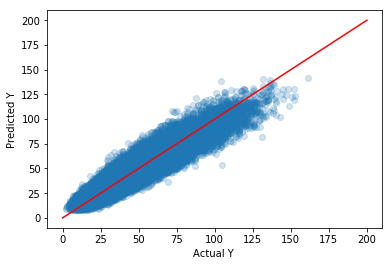

In [24]:
plot_preds(predictions_valid, y_valid)

## All In

In [25]:
%%time
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1)
rf.fit(train, sales)

Wall time: 4min 39s


In [26]:
y_pred = rf.predict(test)

# Submission

In [27]:
submission = pd.read_csv(f'{PATH}test.csv', index_col='id')

In [28]:
submission['sales'] = y_pred

In [29]:
csv_fn = f'{PATH}tmp/RF_v2.csv'

In [30]:
submission[['sales']].to_csv(csv_fn)

# Feature Importance

<BarContainer object of 9 artists>

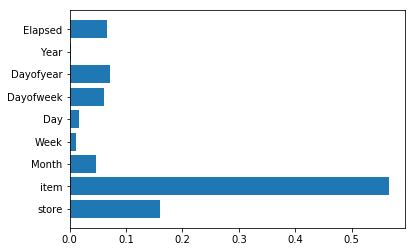

In [31]:
plt.barh(X_train.columns, rf.feature_importances_)